In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import tensorflow as tf
import numpy as np
from tflearn.layers.conv import conv_1d
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.external.structural_pc_losses import losses
from general_tools.notebook.tf import reset_tf_graph
from tf_lab.data_sets.numpy_dataset import NumpyDataset
from geo_tool import Point_Cloud

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from pc_completions.helper import load_pretrained_ae_from_iclr
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.convenience import get_latent_codes
from general_tools.clustering.convenience import find_nearest_neighbors

In [3]:
from tf_lab.point_clouds.convenience import reconstruct_pclouds

In [4]:
%matplotlib inline

In [5]:
class_name = 'chair'

In [6]:
syn_id = snc_category_to_synth_id()[class_name]
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
train_clouds = in_data['train'].point_clouds

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [42]:
# pretrained_ae = load_pretrained_ae_from_iclr(class_name=class_name, loss='chamfer', bneck=128, pc_type='uniform_one')
# latent_codes = get_latent_codes(pretrained_ae, train_clouds)
recon_pclouds, loss_val = reconstruct_pclouds(pretrained_ae, in_data['val'].point_clouds, 100)
print 'Loss of reconstructed data ', loss_val

Loss of reconstructed data  0.000635464374009


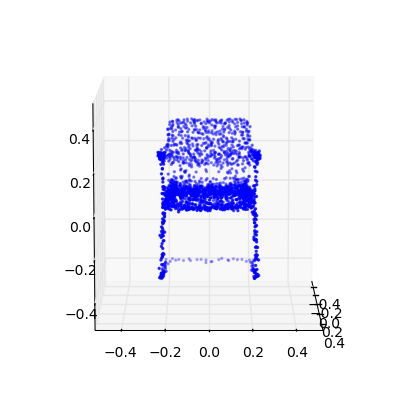

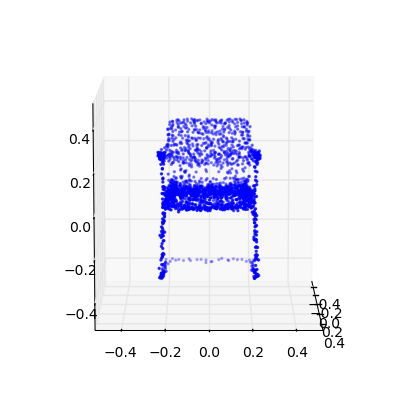

In [115]:
rid = np.random.randint(len(recon_pclouds))
Point_Cloud(recon_pclouds[rid]).plot(azim=0)

In [ ]:
reset_tf_graph()
sess = tf.InteractiveSession()

n_points = 2048
pc_dim = 3

x = tf.placeholder(tf.float32, [None, n_points, pc_dim])
y = tf.placeholder(tf.float32, [None, n_points, pc_dim])

enc_filters = [64, 128, 128, 256]
mask_neurons = [100, 100, n_points]
decoder_neurons = [128, 256, n_points * 3]

with tf.variable_scope('encoder') as scope:    
    zx = encoder_with_convs_and_symmetry_new(x, n_filters=enc_filters, b_norm=False, scope=scope)
    zx_sim = zx[:, :128] #TODO make general
    zx_dissim = zx[:, 128:]
    zy = encoder_with_convs_and_symmetry_new(y, n_filters=enc_filters, b_norm=False, scope=scope, reuse=True)
    zy_sim = zy[:, :128]
    zy_dissim = zy[:, 128:]
    
with tf.variable_scope('mask_creator') as scope:
    mask = decoder_with_fc_only(zx, layer_sizes=mask_neurons, b_norm=False, scope=scope)
    mask_x_sim = tf.sigmoid(mask) >= 0.5
    mask_x_dissim = tf.logical_not(mask_x_sim)
    
    mask_x_sim = tf.tile(tf.expand_dims(mask_x_sim, 2), [1, 1, pc_dim])  # TODO d-check
    mask_x_sim = tf.cast(mask_x_sim, tf.float32)    
    mask_x_dissim = tf.tile(tf.expand_dims(mask_x_dissim, 2), [1, 1, pc_dim])  # TODO d-check
    mask_x_dissim = tf.cast(mask_x_dissim, tf.float32)
        
    mask = decoder_with_fc_only(zy, layer_sizes=mask_neurons, b_norm=False, scope=scope, reuse=True)
    mask_y_sim = tf.sigmoid(mask) >= 0.5
    mask_y_dissim = tf.logical_not(mask_y_sim)
    
    mask_y_sim = tf.tile(tf.expand_dims(mask_y_sim, 2), [1, 1, pc_dim])  # TODO d-check
    mask_y_sim = tf.cast(mask_y_sim, tf.float32)    
    mask_y_dissim = tf.tile(tf.expand_dims(mask_y_dissim, 2), [1, 1, pc_dim])  # TODO d-check
    mask_y_dissim = tf.cast(mask_y_dissim, tf.float32)

with tf.variable_scope('sim_decoder') as scope:
    x_sim_pred = decoder_with_fc_only(zx_sim, layer_sizes=decoder_neurons, b_norm=False, scope=scope)
    x_sim_pred = tf.reshape(x_sim_pred, [-1, n_points, pc_dim])
    y_sim_pred = decoder_with_fc_only(zy_sim, layer_sizes=decoder_neurons, b_norm=False, scope=scope, reuse=True)
    y_sim_pred = tf.reshape(y_sim_pred, [-1, n_points, pc_dim])

with tf.variable_scope('dissim_decoder') as scope:    
    x_dissim_pred = decoder_with_fc_only(zx_dissim, layer_sizes=decoder_neurons, b_norm=False, scope=scope)
    x_dissim_pred = tf.reshape(x_dissim_pred, [-1, n_points, pc_dim])
    y_dissim_pred = decoder_with_fc_only(zy_dissim, layer_sizes=decoder_neurons, b_norm=False, scope=scope, reuse=True)
    y_dissim_pred = tf.reshape(y_dissim_pred, [-1, n_points, pc_dim])
    
with tf.variable_scope('ae_losses') as scope:
    x_sim_masked = tf.multiply(x, mask_x_sim)
    x_dissim_masked = tf.multiply(x, mask_x_dissim)    
    
    y_sim_masked = tf.multiply(y, mask_y_sim)
    y_dissim_masked = tf.multiply(y, mask_y_dissim)
    
    _, _, s1, _ = nn_distance(x_sim_pred, y_sim_masked)
    _, _, s2, _ = nn_distance(x_dissim_pred, x_dissim_masked)
    _, _, s3, _ = nn_distance(y_sim_pred, x_sim_masked)
    _, _, s4, _ = nn_distance(y_dissim_pred, y_dissim_masked)
    ae_loss = tf.reduce_mean(s1 + s2 + s3 + s4)
    
    total_loss = ae_loss